# Control software development and TCLab Introduction

This lecture will look at the information processing part of a mechatronic system in terms of control loops and digital implementation of controllers. 

*Information processing part of a mechatronic system:*
![Mechatronics](./figures/mechatronics.png)

## Digital controller development cycle

Software components and digital controllers are becoming essential in the development of new automated systems.  They offer a wide range of functions at low cost and are flexible in terms of use and maintenance. However, development times are potentially long with specific stages and test times to detect coding errors.

To maximise the benefits of the software and minimise the disadvantages of development, engineers have access to tools at the various stages of the V cycle:
- **MIL or Model In the Loop:** the controller principle is tested by simulation.  
- **RCP or Rapid Control Prototyping:** a digital implementation of the controller is implemented in a powerful dedicated processor. The code is generated using specific tools. The physical system is real and can take the form of a reduced-scale model or part of the system.   
- **SIL or Sofwtare In the Loop:** the controller software code is computer-tested on a simulated physical system.  
- **HIL or Hardware In the Loop:** the software code is implemented in the product's digital controller. This software/controller assembly is tested electronically on a simulated physical system in an HIL digital target.  

**Software V design cycle:**  
![Mechatronics](./figures/VcycleHIL.jpg)

> **Question:** Using the example of the control of a gyropode (segway), indicate which stage in the development of the digital controller each image below corresponds to.

**HIL quiz:**  
![HIL quiz](./figures/HIl_quiz.png)

:::{dropdown} Answer  
(d) MIL: Simulation model with controller principle 

(b) RCP: Cylinder test bench with DSPACE controller

(a) SIL: Simulation model with software and clock sampling 

(c ) HIL: microcontroller electronic board with HIL target
:::

## Digitizing a controller and the effect of sampling frequencies

### Nested loops of a position control

We will illustrate the effects of digitisation on a launcher nozzle TVC controller. The TVC actuator considered here is an EMA (Electro-Mechanical) linear actuator. Its body is anchored on the booster frame while its rod is attached to the nozzle. In the normal mode, the TVC Actuator must perform a closed loop angular position control of the nozzle, following the demand of the flight control computer and rejecting the disturbances generated by the pulsed jet throught the nozzle. The TVC Actuator must also behave as a damper in order to limit the mechanical resonance effects.

**TVC actuator: position and tests**  
![TVC test](./figures/TVA_system.png)
![TVC test](./figures/TVC_tests.png)

Each of the 2 actuators consists of a brushless permanent magnet synchronous motor that drives a roller screw through a gearbox. This way the rotational motion of the motor is transformed into a linear motion. A typical and generic architecture of small loop controller (big loop = launcher control) is represented below. Classical approach for the design of loop control foresees multiple nested loops (cascade):
- The inner current or torque loop is generally associated to a much larger bandwidth than the other loops. 
- A velocity loop:  for EMA, the motor angular position is measured using a resolver and derived to obtain a velocity feedback. A force sensor is added to drive the actuator in order to reduce the transient force and to damp oscillations. 
- A external position loop: technical constraints impose to have a feedback on actuator position rather than nozzle position itself (which is the controlled parameter). LVDT sensor is generally used to measure the length variation of the actuator. 

**EMA actuator:**  
![TVC test](./figures/SmallLoopController.PNG)
![TVC test](./figures/P80EMA.PNG)

> **Question:** Explain in simplified terms how force feedback can be used to introduce damping.

:::{dropdown} Damping with forcefeedback
The force feedback is achieved by measuring the force generated by the actuator, using an instrumented rod end for example, and by using this measurment as a setpoint on the speed loop. 

A proportional link is therefore created between the actuator force and the linear speed, similar to that of a viscous damper. The gain applied on the force feedback enables to set the damping. 
:::

### Speed loop of an EMA

We will focus here on the speed loop. We will represent the mechanical assembly nozzle / actuator by the diagram a) below with:
- the mass/spring/viscous friction assembly for the nozzle
- the rack-and-pinion assembly representing the screw/nut system and the EMA motor

*Mechanical models:*
![TVC test](./figures/EMA_Nozzle_Modelica.png)


> **Exercice:** Explain how to represent the previous model a) by the equivalent model in rotation b). Determine the transfer function relating torque to motor speed under these conditions.

:::{dropdown} Equivalent parameters
The equivalent parameters must make it possible to represent :
- the kinetic energy $\frac{1}{2}M_{nozzle}v^2=\frac{1}{2}J_{eq}\Omega^2$ thus $J_{eq,nozzle}=M_{nozzle}p^2$ with $p$ the pitch in [m/rad]    
or  
- elastic energy  $\frac{1}{2}K_{nozzle}x^2=\frac{1}{2}K_{eq}\theta^2$ thus $K_{eq,nozzle}=K_{nozzle}p^2$ with $p$ the pitch in [m/rad]  

stored in the system as a whole.

Finally:  
$J_{eq}=J_{mot}+M_{nozzle}p^2$  
$K_{eq}=K_{nozzle}p^2$  
$f_{eq}=f_{nozzle}p^2$
:::

:::{dropdown} Transfer function
$\frac{\Omega(p)}{T(p)}=\frac{p}{K_{eq}+f_{eq}p+J_{eq}p^2}$
:::

The Bode diagram of the transfer function can be displayed using the [python-control library](https://python-control.readthedocs.io/en/0.9.4/). 

In [1]:
try:
    import control as ct
except ImportError as e:
    # Install Python-Control package
    !pip install control 

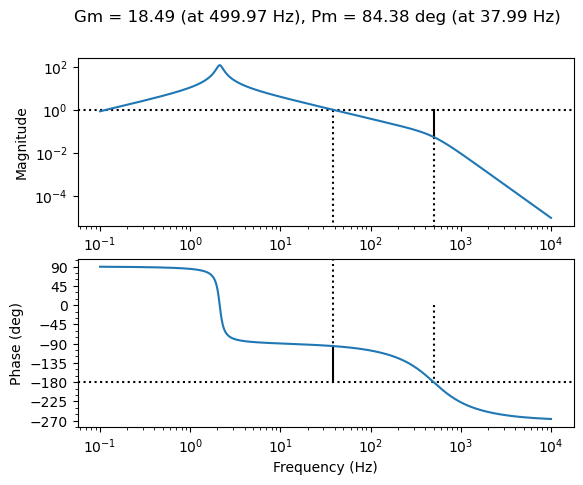

In [4]:
import control as ct

# Parameters
pitch=1.25e-3 # [m/rad] pitch
Jmot=3e-3 # [kg] motor inertia
fn=5475 # [N/(m/s)] nozzle  equivalent viscous friction 
Mn=770 # [kg] Nozzle equivalent mass
Kn=478000 # [N/m] Nozzle equivalent stiffness

# Rotational equivalent parameters
Jeq=Mn*pitch**2
Keq=Kn*pitch**2
feq=fn*pitch**2
Jtot=Jmot+Jeq

# Transfer function
sys_meca = ct.tf([1, 0], [Jtot, feq, Keq])
sys_iLoop = ct.tf(1, [1/(2*3.14*500)**2, 2*0.7/(2*3.14*500), 1])
sys_open=sys_iLoop*sys_meca

# Bode diagram
mag, phase, omega= ct.bode_plot(sys_open, plot=True, Hz=True, initial_phase=90,margins=True)

> **Exercice:** Propose a corrector with zero static error and a closed bandwidth of 40 Hz. Make sure you have a minimum phase margin of 45° and a minimum gain margin of 10 dB. 

:::{dropdown} Controller definition  
The static error requires the addition of an integral term. We can therefore propose a PI corrector if the stability conditions allow.  
$C(p)=K_p(1+\frac{1}{\tau_i p})=\frac{K_p+K_p\tau_i p}{\tau_i p}$

The bandwidth in the closed loop can be approximated in the open loop by the frequency with unity gain. 
:::

PI controller:
Kp = 1.05
Tau = 3.18e-02


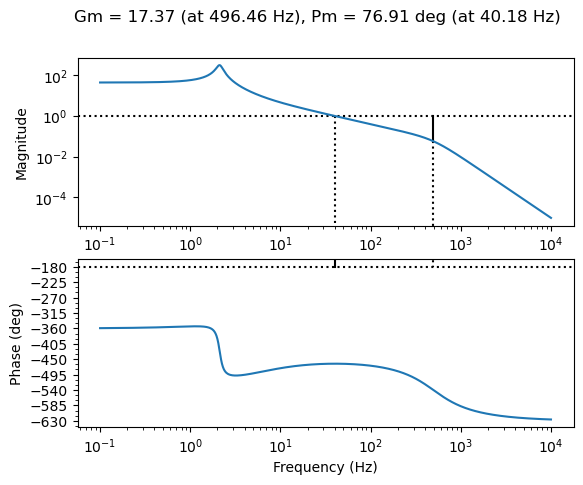

In [7]:
# PI controller
Kp=1.05
tau_i=1/(5*2*3.14)
PI=ct.tf([Kp*tau_i, Kp], [tau_i, 0])

# Open loop
PISys=PI*sys_open

# Bode diagram
mag, phase, omega= ct.bode_plot(PISys, plot=True, Hz=True, margins=True, grid=True)

print("PI controller:")
print("Kp = %.2f"% Kp)
print("Tau = %.2e"% tau_i)


### Delay in digital controller

The previous synthesis of the corrector was done in the continuous domain. However, its implementation will most often be digital rather than analogue. Digital control (using a µC microcontroller or a DSP signal processor) offers the following advantages [[Ellis, 2012](#References)]:
- lower noise sensitivity, better accuracy, less performance drift  
- ease of changing gains or parameters.  
However, digital control has one main weakness: the introduction of delay in the control loop. These delays generate phase shifts that can lead to instability or limit the gains and ultimately the bandwidth of the system. 

Digital systems operate in discrete time steps. At regular intervals, the controller reads the feedback and command information, executes control algorithms, and outputs control orders. Between intervals, the output is held at a fixed level. This is what gives digital control waveforms their characteristic "stair step" appearance. The figure below shows a sinusoidal waveform at its sampled equivalent. The effect of sampling with a period T can be approximated as a pure delay of T/2.  

*Sampling effects:*
![Sampling](./figures/SamplingDelay.PNG)

> **Exercice:**  Characterise the effect of sampling on gain and phase. Perform the numerical applications for a sampling period of 8 ms (125 Hz).

**Note:** Delays can be approximated by Padé transfer functions with python implementation in the [control package](https://python-control.readthedocs.io/en/latest/generated/control.pade.html). A first-order Padé approximation of a T time delay is $e^{-Tp}=\frac{1-\frac{T}{2}p}{1+\frac{T}{2}p}$

<Figure size 640x480 with 0 Axes>

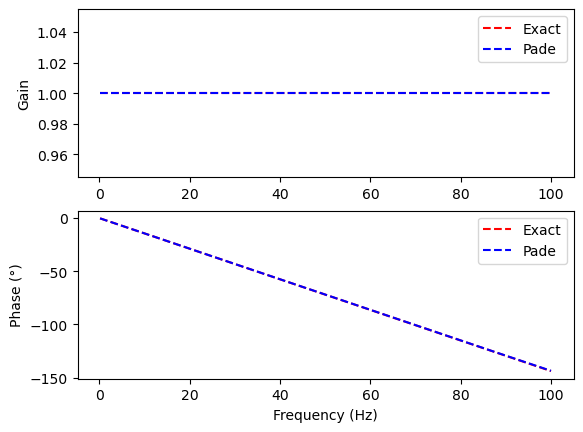

In [19]:
delay=0.008/2
#pade=ct.tf(ct.pade(delay, 1))
num,den=ct.pade(delay, 3)
pade=ct.tf(num,den)

mag, phase, omega= ct.bode_plot(pade, plot=False, omega_limits=[1,2*3.14*100], Hz=False)
                        

import matplotlib.pyplot as plt
import numpy as np

freq=omega/2/np.pi

plt.tight_layout()
fig, (ax1, ax2) = plt.subplots(2)    # get subplot axes

plt.sca(ax1)                 # magnitude plot
plt.plot(freq, [1]*len(omega),'r--', label='Exact')
plt.plot(freq, mag,'b--', label='Pade')
plt.ylabel('Gain')
plt.legend()

plt.sca(ax2)                 # phase plot
plt.plot(freq,-delay*omega*180/np.pi,'r--', label='Exact')
plt.plot(freq, phase*180/np.pi,'b--', label='Pade')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (°)')
plt.legend()

**Note:** Delays can come from a variety of sources:
- Sample-and-hold: 0.5T  
- Calculation delay: 0.1T-0.9T  
- Velocity estimation: 0.5T (motion systems)  

Their effects are added together to produce a total delay. The anti-aliasing filter can also create phase shifts that need to be taken into account. The sampling frequency must be chosen carefully with all these effects. 

> **Exercice:** Evaluate the effect of sampling at a period of 8 ms on the previous corrector. Suggest a sampling frequency compatible with the desired performance.

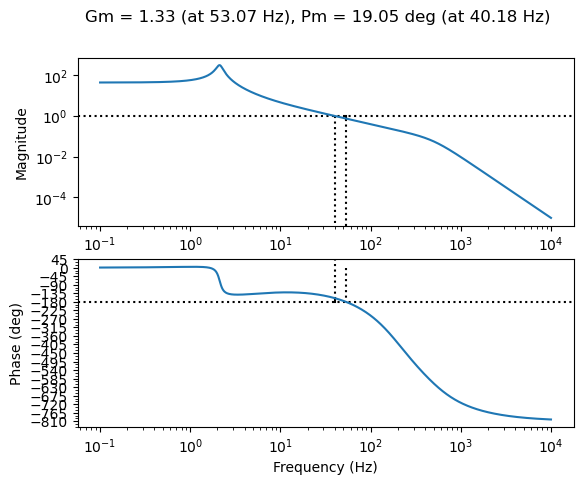

In [21]:
PISysPade=PISys*pade
mag, phase, omega= ct.bode_plot(PISysPade, plot=True, Hz=True, initial_phase=90, margins=True, grid=False)


## References

[Mihalič, 2022 ] Mihalič, F., Truntič, M., & Hren, A. (2022). Hardware-in-the-loop simulations: A historical overview of engineering challenges. Electronics, 11(15), 2462. [Link](https://www.researchgate.net/publication/362572593_Hardware-in-the-Loop_Simulations_A_Historical_Overview_of_Engineering_Challenges)

[Vanthuyne, 2009 ] Vanthuyne, T. (2009, September). An electrical thrust vector control system for the VEGA launcher. In Proceedings of the 13th European Space Mechanisms and Tribology Symposium (Vol. 670). [Link](http://esmats.eu/esmatspapers/pastpapers/pdfs/2009/vanthuyne.pdf)

[Carpentier, 2011 ] Carpentier, B., Puel, F., Cros, C., Pin, B., Gerbe, L., & Solide, S. S. P. (2011). Stability analysis using a coupled model of TVC actuator control loop and structural dynamics of a Launch Vehicle. In 4th European Conference For Aerospace Sciences (EUCASS). 

[Ellis, 2012] Ellis, G. (2012). Control system design guide: using your computer to understand and diagnose feedback controllers. Butterworth-Heinemann.